In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dfUrl = 'https://www2.census.gov/programs-surveys/popproj/datasets/2017/2017-popproj/np2017_d1_mid.csv'

df = pd.read_csv(dfUrl)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Columns: 106 entries, SEX to POP_100
dtypes: int64(106)
memory usage: 3.9 MB


In [2]:
print(f'Rows: {df.shape[0]:,}')
print(f'Columns: {df.shape[1]:,}')

Rows: 4,860
Columns: 106


In [3]:
df.columns

Index(['SEX', 'ORIGIN', 'RACE', 'YEAR', 'TOTAL_POP', 'POP_0', 'POP_1', 'POP_2',
       'POP_3', 'POP_4',
       ...
       'POP_91', 'POP_92', 'POP_93', 'POP_94', 'POP_95', 'POP_96', 'POP_97',
       'POP_98', 'POP_99', 'POP_100'],
      dtype='object', length=106)

## File layout
- SEX: sex, see key  
- ORIGIN: Hispanic origin, see key  
- RACE: see key  
- YEAR: year of population projection  
- TOTAL_POP: total population, all ages combined  
- (POP_0, POP_1, ...POP_99, POP_100): population for given age  

The key for ORIGIN is as follows:
- 0 = Total  
- 1 = Not Hispanic  
- 2 = Hispanic  

The key for RACE is as follows:
- 0 = All races (codes 1 through 6)  
- 1 = White alone  
- 2 = Black alone  
- 3 = AIAN alone  
- 4 = Asian alone  
- 5 = NHPI alone  
- 6 = Two or More Races  
- 7 = White alone or in combination  
- 8 = Black alone or in combination  
- 9 = AIAN alone or in combination  
- 10 = Asian alone or in combination  
- 11 = NHPI alone or in combination

The key for SEX is as follows:
- 0 = Both sexes  
- 1 = Male  
- 2 = Female  
      
NOTE: Hispanic origin is considered an ethnicity, not a race. Hispanics may be of any race.

## Original question:
We need to understand what the 85+ population looks like over time and understand trends in its annual growth rate. Probably don't need to worry about ORIGIN, RACE, or SEX so we can filter down to the aggregate values.

## Things to consider
- This dataset is very wide, likely want to consider converting to a long format  
- There are aggregations included with the raw data
- Haven't determined if there are nulls/missing data yet   

### Let's get checking for null values out of the way!

In [4]:
df.isna().sum().value_counts(dropna=False)

0    106
dtype: int64

In [5]:
df.dropna().shape

(4860, 106)

#### No missing values in any of the columns!

### But we still have a very wide dataset, so we should convert it to long dataset via "melt".
And we'll want to filter down to the overall population by year.

In [6]:
dfLong = (
    df.query("ORIGIN==0 and RACE==0 and SEX==0")
    .drop(columns=['ORIGIN','RACE','SEX','TOTAL_POP'])
    .melt(id_vars='YEAR', var_name='POP_AGE', value_name='POP')
)

dfLong.head()

,YEAR,POP_AGE,POP
0,2016,POP_0,3970145
1,2017,POP_0,4054035
2,2018,POP_0,4075563
3,2019,POP_0,4095614
4,2020,POP_0,4113164


### Extract the age

In [7]:

dfLong['AGE'] = dfLong['POP_AGE'].apply(lambda x: int(x.split('_')[1]))
dfLong = dfLong.drop(columns=['POP_AGE'])
dfLong.head()

,YEAR,POP,AGE
0,2016,3970145,0
1,2017,4054035,0
2,2018,4075563,0
3,2019,4095614,0
4,2020,4113164,0


### Let's look at the distribution for 2021

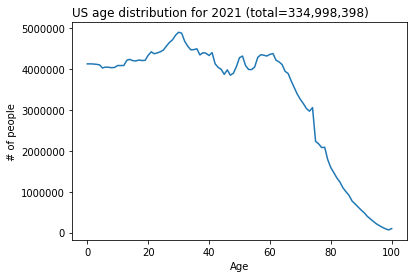

In [8]:
(
    dfLong.query('YEAR==2021')
    .plot(x='AGE', y='POP', kind='line', legend=False)
)

plt.title(f'US age distribution for 2021 (total={dfLong.query("YEAR==2021")["POP"].sum():,})', loc='left')
plt.xlabel('Age')
plt.ylabel('# of people')
plt.show()

### Make sure that total squares: https://www.census.gov
You want to avoid showing data that is levels of magnitude out of expected bounds.

### How will this shape compare against 2050?

In [12]:
yearCompare = (
    dfLong.query('YEAR==2021 or YEAR==2050')
    .pivot_table(index='AGE', columns='YEAR', values='POP')
)

yearCompare.head()

YEAR,2021,2050
AGE,,
0,4127525,4313446
1,4127842,4319726
2,4124416,4324259
3,4116205,4326295
4,4105035,4326735


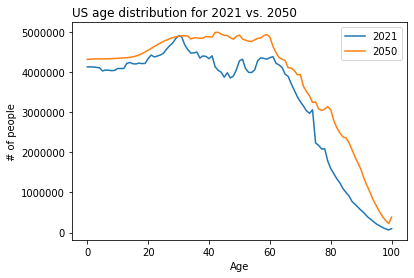

In [13]:
yearCompare.plot(kind='line')
plt.title(f'US age distribution for 2021 vs. 2050', loc='left')
plt.xlabel('Age')
plt.ylabel('# of people')
plt.legend(title='')
plt.show()

#### This is probably more meaningful on a percent basis since population will grow over time. We should probably account for population differences and measure this on a percent basis.

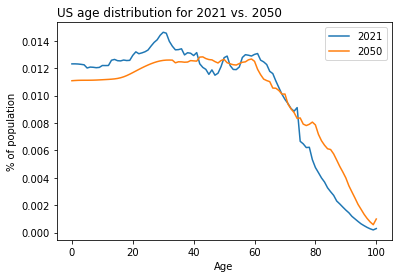

In [15]:
(
    yearCompare.div(yearCompare.sum(axis=0), axis=1)
    .plot(kind='line')
)

plt.title(f'US age distribution for 2021 vs. 2050', loc='left')
plt.xlabel('Age')
plt.ylabel('% of population')
plt.legend(title='')
plt.show()

#### How does this compare with the prior plot?
This shows that on average, the population is aging. The original plot seemed to show more younger individuals in the out year, but that's a product of a larger overall population. We should observe the growth rate for the older population increasing, as a way to check our math.

### Let's create our growth rate plot

In [17]:
pop85 = (
    dfLong.query('AGE>84')
    .groupby('YEAR')['POP'].sum()
)

pop85Growth = pop85 / pop85.shift(1) - 1
pop85Growth.head()

YEAR
2016         NaN
2017    0.013726
2018    0.011039
2019    0.007816
2020    0.016762
Name: POP, dtype: float64

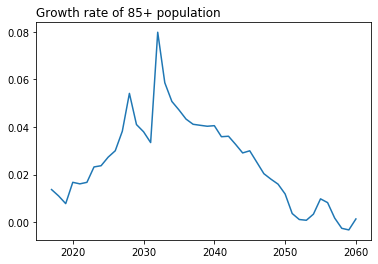

In [18]:
pop85Growth.plot(kind='line')
plt.title('Growth rate of 85+ population', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Growth rates help show the growth, but having a baseline, maybe the under 84 age group would be helpful to see the contrast.

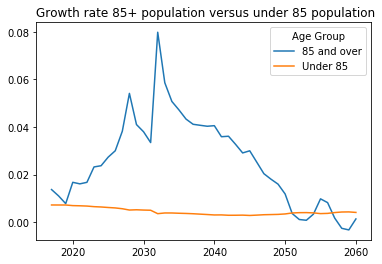

In [23]:
popU84 = (
    dfLong.query('AGE<85')
    .groupby('YEAR')['POP'].sum()
)

popU84Growth = popU84 / popU84.shift(1) - 1

pop85Growth.plot(kind='line')
popU84Growth.plot(kind='line')
plt.title('Growth rate 85+ population versus under 85 population', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.legend(['85 and over','Under 85'], title='Age Group')
plt.show()

## We can also look at different parts of the distribution over time?
We can cut the data into bins, if you aren't familiar, you can look at the documentation:

```python
help(pd.cut)
```

In [19]:
dfLong['AGE_BINS'] = pd.cut(dfLong['AGE'], 6)
dfLong.head()

,YEAR,POP,AGE,AGE_BINS
0,2016,3970145,0,"(-0.1, 16.667]"
1,2017,4054035,0,"(-0.1, 16.667]"
2,2018,4075563,0,"(-0.1, 16.667]"
3,2019,4095614,0,"(-0.1, 16.667]"
4,2020,4113164,0,"(-0.1, 16.667]"


In [20]:
dfLong['AGE_BINS'].value_counts()

(83.333, 100.0]     765
(66.667, 83.333]    765
(33.333, 50.0]      765
(16.667, 33.333]    765
(-0.1, 16.667]      765
(50.0, 66.667]      720
Name: AGE_BINS, dtype: int64

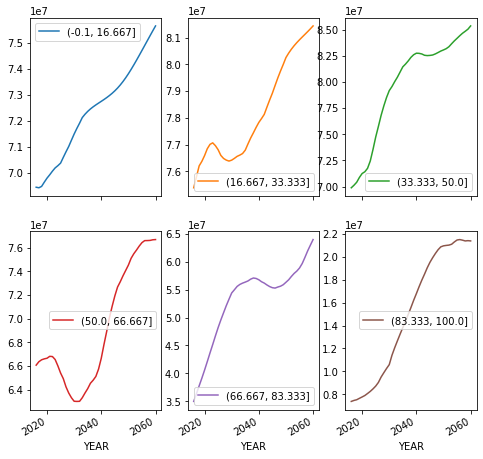

In [25]:
(
    dfLong
    .pivot_table(index='YEAR', columns='AGE_BINS', values='POP', aggfunc='sum')
    .plot(kind='line', subplots=True, layout=(2,3), figsize=(8,8))
)
plt.show()

This is interesting. Beginning in the mid-2020s into the early-2030s, some groups are actually experiencing declines in their population. It looks like there will also be unfettered growth in the youngest age groups.

#### Let's peel the onion more. Let's look at which races may be driving some of these trends.
> Remember "0 = All races (codes 1 through 6)  "

In [21]:
raceFilter = [1,2,3,4,5,6]

raceMap = {1:'White alone',
           2:'Black alone',
           3:'AIAN alone', 
           4:'Asian alone', 
           5:'NHPI alone', 
           6:'Two or More Races'
          }

In [22]:
dfLongRace = (
    df.query("ORIGIN==0 and RACE==@raceFilter and SEX==0")
    .drop(columns=['ORIGIN','SEX','TOTAL_POP'])
    .melt(id_vars=['YEAR','RACE'], var_name='POP_AGE', value_name='POP')
)

dfLongRace['RACE_DESC'] = dfLongRace['RACE'].map(raceMap)
dfLongRace['AGE'] = dfLongRace['POP_AGE'].apply(lambda x: int(x.split('_')[1]))
dfLongRace = dfLongRace.drop(columns=['POP_AGE', 'RACE'])

dfLongRace.head()

,YEAR,POP,RACE_DESC,AGE
0,2016,2841126,White alone,0
1,2017,2851648,White alone,0
2,2018,2859491,White alone,0
3,2019,2866210,White alone,0
4,2020,2871107,White alone,0


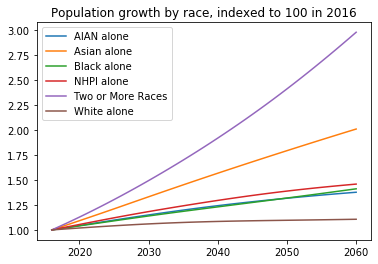

In [23]:
dfRacePivot = dfLongRace.pivot_table(index='YEAR', columns='RACE_DESC', values='POP', aggfunc='sum')

(dfRacePivot/dfRacePivot.iloc[0,:]).plot(kind='line')
plt.title('Population growth by race, indexed to 100 in 2016')
plt.legend(title='')
plt.xlabel('')
plt.show()

#### Looks like diversity is expected to increase in the United States, but what about how that translates to the 85+ population?

In [30]:
dfLongRace.head()

,YEAR,POP,RACE_DESC,AGE
0,2016,2841126,White alone,0
1,2017,2851648,White alone,0
2,2018,2859491,White alone,0
3,2019,2866210,White alone,0
4,2020,2871107,White alone,0


In [31]:
dfRacePivot = (
    dfLongRace.query('AGE >= 85')
    .pivot_table(index='YEAR', columns='RACE_DESC', values='POP', aggfunc='sum')
)

dfRacePivot.head()

RACE_DESC,AIAN alone,Asian alone,Black alone,NHPI alone,Two or More Races,White alone
YEAR,,,,,,
2016,29742,239911,485376,5054,42288,5577960
2017,30802,244130,495084,5230,43574,5649085
2018,31997,249924,507297,5428,44858,5699802
2019,33121,255306,519467,5705,46299,5730516
2020,34795,263064,536214,6003,48142,5812662


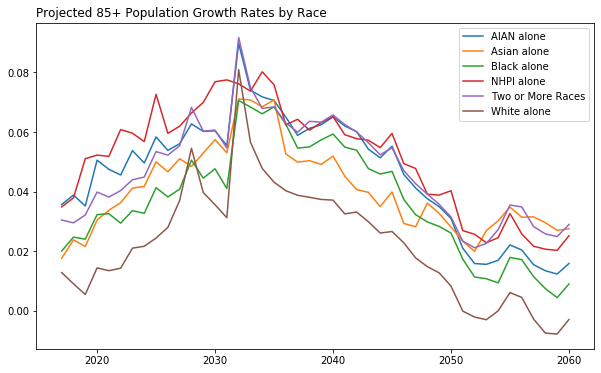

In [32]:
(dfRacePivot/dfRacePivot.shift(1) - 1).plot(figsize=(10,6))
plt.legend(title='')
plt.xlabel('')
plt.ylabel('')
plt.title('Projected 85+ Population Growth Rates by Race', loc='left')
plt.show()